Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'
data_file = 'data/text8.zip'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, data_file)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified data/text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
# this controls how many words we consider at all
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  
  # here we limit the size to "vocabulary_size".
  # count is like [['UNK', -1], ['a', 1234], ...]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
        
    # UNK is also added to "data" for all least common words.    
    data.append(index)
    
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

# words: a list of words in order it appears
# count: list of tuples of word and count
# dictionary: word to numeric index
# data: word index. each word maps to its index, unless for unpopular words, which is unknown
# reverse dictionary: index to word
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5238, 3083, 12, 6, 195, 2, 3135, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

# batch_size: guaranteed to return number of data/labels = batch_size
# num_skips: how many to examples sample. could throw away some data if num_skips < 2*skip_window
# skip_window: how many words to look forward/backward to the current word.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window

  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        # here is a random. looks like we are throwing aways some data randomly based on num_skips
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  return batch, labels

# print first 8 words of the text
print('data:', [reverse_dictionary[di] for di in data[:8]])

# This is just to give people an idea of how generate_batch works. batch and labels are not used here.
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('shapes:', batch.shape, labels.shape)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
shapes: (8,) (8, 1)
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
shapes: (8,) (8, 1)
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'term', 'a', 'as', 'of', 'originated', 'term']


Train a skip-gram model.

In [33]:
batch_size = 100
embedding_size = 128 # Dimension of the embedding vector.

skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.

# from 0~100, sample 16 numbers as a 1D tensor
valid_examples = np.array(random.sample(range(valid_window), valid_size))
#print(valid_examples)

num_sampled = 60 # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

  # constant: 16 examples from 0~100 
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.

  # this is the embeddings we try to generate.
  # for each word in vocabulary, we have a embedding in "embedding_size"
  # the initial value is draw from a uniform distribution in [-1.0, 1.0]
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
  # this has the same shape as embeddings, but initial vale is drawn from a normal distribution
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  # this is the biases for each word in vocabulary
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # "embeddings" has all vocabulary embeddings; train_dataset is "IDs".
  # embeddings shape: 50000x128, train_dataset: 100  
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # According to the experiment code below, embed has shape 100x128
  # That is, we only look at the embeddings from the exmaples in train_dataset.
  # tf.nn.embedding_lookup seems to find the examples from train_dataset, which is by data index.
    
  # This piece of code is to help understand what tf.nn.embedding_lookup really does.
  # According to documentation, embed's shape should be "shape(ids) + shape(params)[1:]"
  # First, we want to see what is "shape(ids) + shape(params)[1:]" and verify embed's shape
  #embed_shape = tf.shape(train_dataset) + tf.shape(embeddings)[1:]
  #print(type(embed_shape), tf.shape(embed_shape), tf.shape(embed), embed_shape.shape, embed.shape)  
    
  # Compute the softmax loss, using a sample of the negative labels each time.
  # A few things to note here regarding tf.nn.sampled_softmax_loss():
  # 1. Labels are not encoded as one-hot vector, but just numeric indexes. => This might facilitate "sample"
  # 2. inputs=embed, which is after applying tf.nn.embedding_lookup, and is not by index, like train_labels.
  # 3. num_sampled => This is THE thing that makes it different: the number of negative examples to sample for softmax_loss
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  # embeddings are not normalized to [-1, 1], and this step normalizes it.
    
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  print(valid_embeddings.shape)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

(16, 128)


In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l # note: this is "L" for loss, not digit 1. very confusing.
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        # this find the nearest neighbors for each item in the valid set.
        # skip the first one because it would always be itself.
        # argsort() returns the index instead of the value.
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)

  # this is normalized, also using "eval()" to convert to regular ndarray instead of tensor.      
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.234884
Nearest to during: spectrometers, undesired, vt, necked, kindling, aureus, uri, esther,
Nearest to from: wer, indic, rosser, gormenghast, violence, strategies, planters, melanesian,
Nearest to that: yassir, labelled, nmr, alphonse, thx, cellars, martins, habakkuk,
Nearest to years: guidebook, straightforwardly, gems, indomitable, cub, ceasing, magnificat, gravesite,
Nearest to on: everywhere, freedom, embark, jabberwocky, inherent, actions, murderous, capillary,
Nearest to their: zirconium, winona, preparing, marcian, hijacker, greed, goodfellas, jong,
Nearest to when: fidonet, differential, roam, nikolaus, taggart, sadi, marcella, dynamical,
Nearest to after: conspiratorial, loud, koi, foreman, intelligence, qua, constable, ultima,
Nearest to b: wasteland, bauds, duffy, marbles, scotch, imperfectly, milius, panyu,
Nearest to only: rainer, ombudsman, extremists, imperative, hieroglyphs, millard, realpolitik, slaughtered,
Nearest to with: fin

In [36]:
# look at data. mostly see what's KNN to "unknown"
word = 'on'
i = dictionary[word]

print(final_embeddings.shape)
ue = final_embeddings[i,:] # ue stands for "unknown_embedding"
# print(ue)
print(ue.shape, final_embeddings.shape)
cos_sim = np.matmul(ue.reshape(1, 128), final_embeddings.transpose())
print(cos_sim.shape)

# do negative to use descending order
nearest = (-cos_sim).argsort()[0,:10]
print(nearest)

log = 'Nearest to %s:' % word
for k in range(10):
  close_word = reverse_dictionary[nearest[k]]
  log = '%s %s,' % (log, close_word)
print(log)

(50000, 128)
(128,) (50000, 128)
(1, 50000)
[   25   407   124   156     5   223 23918    35   107 28596]
Nearest to on: on, upon, through, against, in, within, affine, at, under, embark,


In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

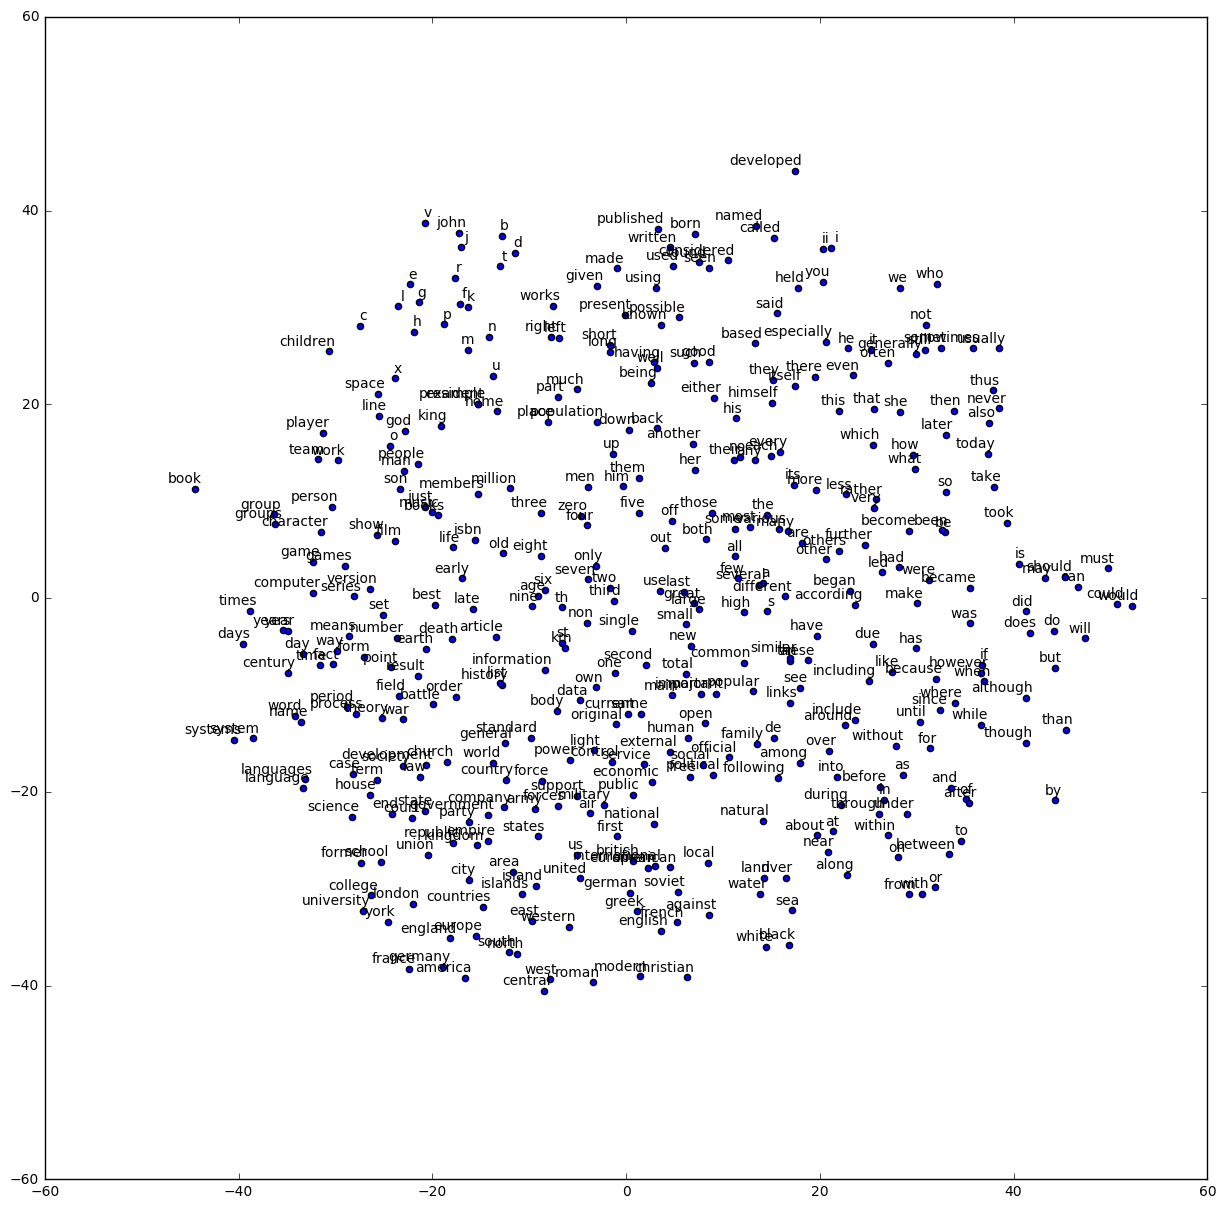

In [11]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

__Daniel's note__: The only difference between skip-Ngram and CBOW, it seems, is about the generator. It's not worth the effort to do CBOW just to change the generator. Instead, do this problem. Have a random generator that output pairs of even numbers or odd numbers. See if Word2Vec can plot even numbers and odd numbers together.

---

In [45]:
vocabulary_size = 100 # numbers between 0 and 99 inclusive
batch_size = 10
embedding_size = 1 # tried 2 as well. but this problem it seems only 1 dimension is good.
num_sampled = 50 # Number of negative examples to sample.
num_steps = 10001


import random
def generate_batch_new(batch_size):
    data, labels = [], []
    while len(data) < batch_size:
        a, b = random.sample(range(vocabulary_size), 2)
        if a % 2 == b % 2:
            data.append(a)
            labels.append(b)
        assert len(data) == len(labels)
    return np.asarray(data, dtype=np.int32), \
           np.asarray(labels, dtype=np.int32).reshape([batch_size, 1])


graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  normalized_embeddings = embeddings / tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch_new(batch_size)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0

  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 4.198138
Average loss at step 2000: 3.300845
Average loss at step 4000: 3.177546
Average loss at step 6000: 3.168737
Average loss at step 8000: 3.162296
Average loss at step 10000: 3.161229


In [46]:
# for 2 dimensions

# pylab.figure(figsize=(15,15))  # in inches
# for i in range(vocabulary_size):
#     x, y = final_embeddings[i,:]
#     pylab.scatter(x, y)
#     pylab.annotate(i, xy=(x, y), xytext=(5, 2), textcoords='offset points',
#                ha='right', va='bottom')
# pylab.show()

# one dimension, print numbers is good
print(final_embeddings)

[[-1.00000012]
 [ 1.00000012]
 [-1.00000012]
 [ 1.00000012]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.00000012]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.00000012]
 [-1.00000012]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-0.99999994]
 [ 0.99999988]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-1.00000012]
 [ 0.99999988]
 [-1.        ]
 [ 1.        ]
 [-1.00000012]
 [ 1.        ]
 [-1.00000012]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-1.00000012]
 [ 1.        ]
 [-1.        ]
 [ 1.00000012]
 [-1.        ]
 [ 1.00000012]
 [-1.        ]
 [ 1.00000012]
 [-0.99999988]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 0.99999988]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.00000012]
 [-1.        ]
 [ 1.        ]
 [-1.        ]
 [ 1.00000012]
 [-1.        ]
 [ 1.        ]
 [-1.     